<a href="https://colab.research.google.com/github/dsliwka/EEMP2023/blob/main/EngagementPredSampleSolutionsWithComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Job Engagement**
----

- We work with the LPP data to train algorithms to predict job engagement
- The first cell is given code that cleans the data and generates a DataFrame dfp that we use for the prediction
- It already standardizes the survey scales (here engagement and the Big5)

In [3]:
import pandas as pd
import numpy as np
from scipy import stats


## Read LPP Data
path_to_data = "https://raw.githubusercontent.com/dsliwka/EEMP2023/main/Data/LPP-CF_1215_v1.csv"
df = pd.read_csv(path_to_data)


## Keep only wave 2 (as here the LPP campus file has more information)
dfp=df[df.welle==2]

## Generate Engagement Scale
dfp=dfp.assign(enga=6-df.filter(regex="menga*").mean(axis=1))

## reverse health scale (as lower numbers represent better health in the survey)
dfp["mgesund_allg"]=6-dfp.mgesund_allg

## keep only rows where we have non-missing data on income, industry & engagement
dfp=dfp[dfp.meink_kateg.isnull()==False]
dfp=dfp[dfp.branche.isnull()==False]
dfp=dfp[dfp.enga.isnull()==False]

## Generate Big5 traits from items
dfp['conscientiousness']= (6-dfp.mbig_gruend +dfp.mbig_faul     + 6-dfp.mbig_effi)/3
dfp['extraversion']=      (6-dfp.mbig_komm   +dfp.mbig_zur      + 6-dfp.mbig_gesell)/3
dfp['neuroticism']=       (6-dfp.mbig_sorgen +dfp.mbig_entsp    + 6-dfp.mbig_nervoes)/3
dfp['openness']=          (6-dfp.mbig_origi	+6-dfp.mbig_kunst  + 6-dfp.mbig_phant  + 6-dfp.mbig_wissb)/4
dfp['agreeableness']=     (dfp.mbig_grob	    +6-dfp.mbig_verzeih+ 6-dfp.mbig_freundl)/3

## drop all rows in which either of the big5 traits are missing
dfp=dfp.dropna(subset=['conscientiousness', 'extraversion', 'neuroticism', 'openness', 'agreeableness'])

## Standardize all personality traits & engagement (i.e. substract the mean and divide by SD)
## Note: for simplicity we here use a function from package sciepy
dfp['conscientiousness'] = stats.zscore(dfp.conscientiousness)
dfp['extraversion'] = stats.zscore(dfp.extraversion)
dfp['neuroticism'] = stats.zscore(dfp.neuroticism)
dfp['openness'] = stats.zscore(dfp.openness)
dfp['agreeableness'] = stats.zscore(dfp.agreeableness)
dfp['enga'] = stats.zscore(dfp.enga)

## drop all columns with missing data:
dfp = dfp.dropna(axis=1)

## keep only subset of the variables
dfp=dfp[['enga','branche', 'ost', 'size',
       'bauswahl_interview', 'bauswahl_ac', 'bauswahl_kognit', 'bauswahl_pers',
       'bauswahl_arbeitsprobe', 'bauswahl_andere', 'bmagespr', 'bzv',
       'bentwplan', 'bbeurt', 'bvargehalt', 'bsonderz_nv', 'bmabefr',
       'bmabind_flexaz', 'bmabind_verg', 'bhomeoff', 'babsent_anz', 'msex',
       'alter', 'mstib', 'mleitung', 'maz_voll_teil', 'mheim', 'maz_freizeit',
       'mwb', 'mmagespr', 'mikt_nutz', 'mgesund_allg', 'mkind_anz_gr',
       'mkindu3','meink_kateg', 'conscientiousness','extraversion','neuroticism','openness','agreeableness']]

## As variable "brache" which contains the industry in which a person is working
## is categorial generate dummy variables for each industry
dfp =pd.get_dummies(dfp, columns=['branche'])

## inspect how many observations are remaining:
print("We have", dfp.shape[0], "observations and", dfp.shape[1], "variables.")


We have 886 observations and 44 variables.


Before we can train the different algorithms we have to specify the variable we want to predict (typically named y; here a Pandas series) and the feature matrix X (here we can just use a DataFrame that includes all variables except the variable we want to predict.


In [4]:
## Assign the variable to be predicted
y = dfp.enga

## Assign the feature matrix (the predictors):
X=dfp.drop(columns='enga')



# **K-Nearest Neighbor Regression**
----

- We have to import the relevant packages
- Note that it is convenient to standardize the whole X-Matrix for a knn regression, as otherwise the distance measure used to determine who is an observations's neighbor depends on the unit of measurement
- While already some variables were standardized in the data cleaning above, we here standardize the rest (when you standardize a standardized variable it does not change it as you subtract 0 and divide by 1)
- We can use the StandardScaler class in sklearn that makes it very easy to standardize all variables in X at the same time
- We save the standardized feature matrix under a different name (XStd), as we later on use the non-standardized version for other algorithms
- Here we train a Knn regression with 5 neighbors

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

XStd=StandardScaler().fit_transform(X)

knn= KNeighborsRegressor(n_neighbors=5).fit(XStd, y)
y_pred=knn.predict(XStd)
print("MSE =  ", round(mean_squared_error(y, y_pred), 2))
print("R² =   ", round(r2_score(y, y_pred),2))


MSE =   0.72
R² =    0.28


**Interpretation:**
- At first sight the R² looks quite good (about 28%)
- Note here that the R²+MSE is close to one. The reason is that engagement is standardized

# **Train and Test R²**
----

- To avoid that our R² estimate is driven by overfitting we only use part of the sample to train the algorithm and check the MSE/R² on the remaining test sample.
- We use the train_test_split function from sklearn to make the split.
- Here we use 70% of the data for training and 30% for the test sample
- The function randomly determines which observation goes into the training and which goes into the test sample
- When we set a specific random state we can assure that the random numbers are the same when you run the code again


In [6]:
from sklearn.model_selection import train_test_split
XStd_train, XStd_test, y_train, y_test = train_test_split(XStd,y, train_size=0.7, random_state=181)

knn= KNeighborsRegressor(n_neighbors=5).fit(XStd_train, y_train)

print("R²_train=", round(r2_score(y_train, knn.predict(XStd_train)),2))
print("R²_test=",  round(r2_score(y_test, knn.predict(XStd_test)),2))

R²_train= 0.27
R²_test= -0.13


**Interpretation**

- While the training R² is similar to the R² in the whole sample, the test R² is very bad
- In fact, here it is negative, that is our prediction is actually worse than just using the mean of engagement (here close to 0 as enga is standardized) as prediction for all obs (which would lead to an R² of about zero)

\

Side note:
- It is generally recommended to standardize the variables after the train test split to keep the two data sets entirely independent. We don't do it here for reasons of convenience.

In [7]:
knn= KNeighborsRegressor(n_neighbors=100).fit(XStd_train, y_train)

print("R²_train=", round(r2_score(y_train, knn.predict(XStd_train)),2))
print("R²_test=",  round(r2_score(y_test, knn.predict(XStd_test)),2))

R²_train= 0.07
R²_test= 0.06


**Interpretation**

- We have increased the number of neighbors from 5 to 100 our prediction gets better and now is actually useful (R² of 6%)

In [8]:
knn= KNeighborsRegressor(n_neighbors=300).fit(XStd_train, y_train)

print("R²_train=", round(r2_score(y_train, knn.predict(XStd_train)),2))
print("R²_test=",  round(r2_score(y_test, knn.predict(XStd_test)),2))

R²_train= 0.03
R²_test= 0.03


**Interpretation**

- When we increase it to 300 the R² again drops
- The changes are driven by the effects of the hyperparameter (k or n_neigbors in the code) on bias and variance.
- When k=5 the algorithm tends to overfits the data as it follows also random patterns very closely - which then don't show in the test data
- When increasing k we reduce variance as the algorithm becomes less flexible but we may increase bias (as it can adapt less well to the true underlying CEF).
- Here the net effect was positive in the move from 5 to 100 but then the increase from 100 to 300 apparently introduced too much bias (relative to the gain through reduced variance)  

# **Decision Trees**
----

- Here we now train a decision tree on the same data
- The key hyperparameter we use is the depth of the tree
- Here we have a depth of 3
- Note: Better use the non standardized version of the X matrix; therefore we here again perform a train/test split on X before fitting the estimator

Train R²= 0.11
Test R²= 0.01


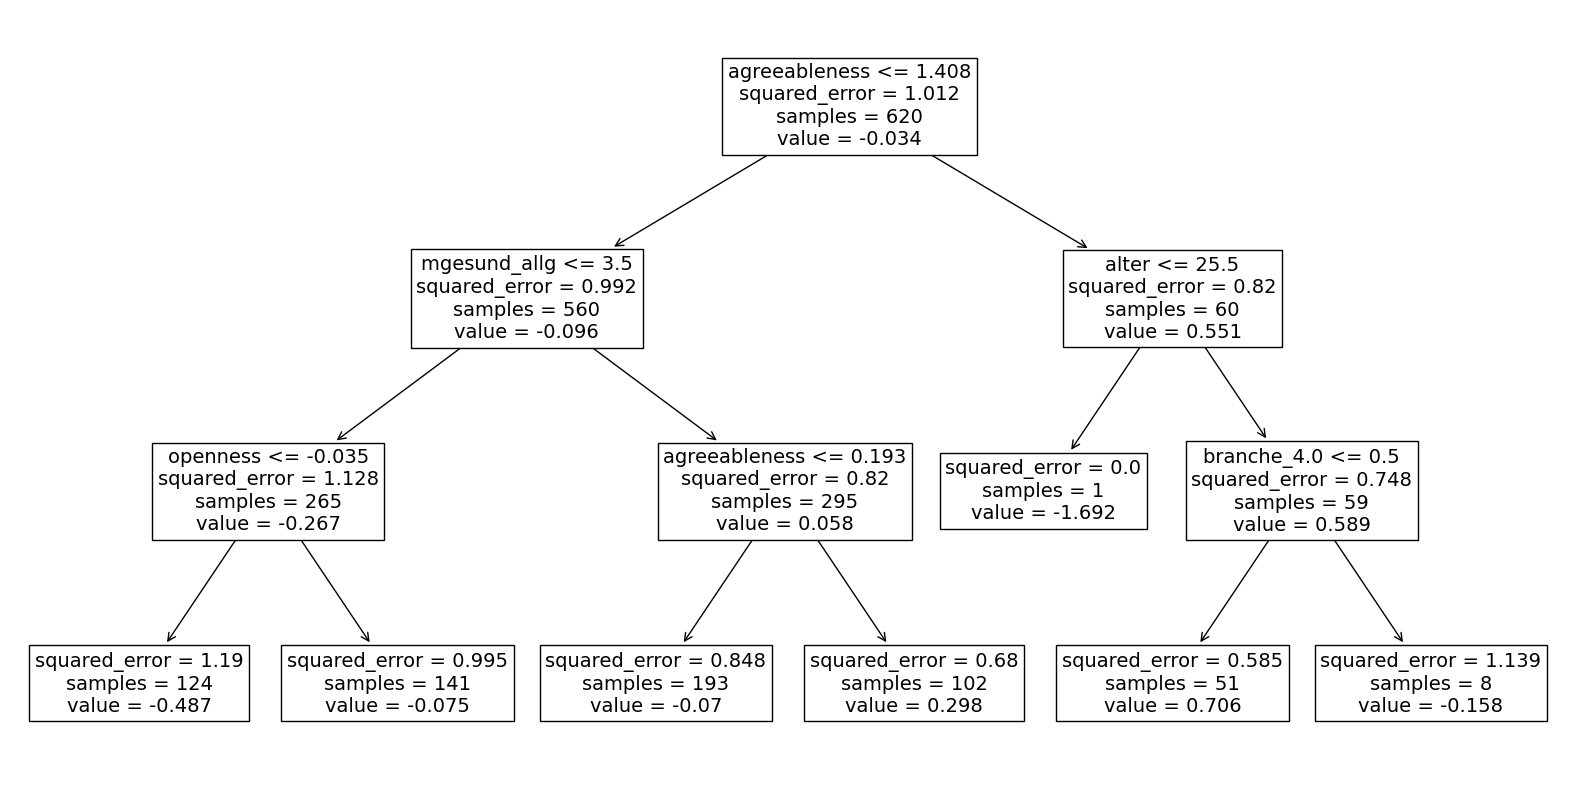

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Split now on non-standardized values
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=181)

dtree = DecisionTreeRegressor(max_depth=3).fit(X_train,y_train)

print("Train R²=",round(r2_score(y_train, dtree.predict(X_train)),2))
print("Test R²=",round(r2_score(y_test, dtree.predict(X_test)),2))

plt.figure(figsize=(20, 10))
plot_tree(dtree, feature_names=X.columns, fontsize =14)
plt.show()

**Interpretation**
- The tree gives us a visual representation of the data
- Here we allowed a depth of three such that we have up to 2³=8 leaves in the tree
- The plot of the tree here also shows the mean value of enga in each leaf, this gives the predicted value of enga for feature vectors that satisfy the path of yes/no conditions at each node up to that leaf.
- The test R² is positive, but small

\

Note:

- We did not specify the hyperparameter min_samples_leaf here. Therefore we have some leafs with very small samples. As this tends to lead to overfiting, it may have hurt the quality of our prediction.
- You can try out whether it helps the quality of the prediction to restrict the min_samples_leaf for instance to 10. This forces the tree not too generate too small leafs and thus reduces overfitting.


# **Random Forests**
----

We here train a random forest, an ensemble of many trees (here 500)
- The RandomForestRegressor class performs all the heavy lifting (using bootsrap aggregation (i.e. drawing different bootstrap samples for each tree) and randomly choosing the subset of feautures that each tree can choose from at each node for splitting the data
- Here we use the square root of the number of all features
- Actually I realized that I had erroneouly claimed that this was the default value (i.e. the setting that the method uses when no value is specified). But it is not, so we have to set it if we want to use the square root of the number of features

\
Side note:
- The default value is set such that when you do not specify something for max_feature then there is no restriction on the number of features used at each node -- the algorithm then just uses bagging to introduce randomness
- This here actually tends to lead to a slightly larger test R²

In [17]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=500, max_features='sqrt', random_state=181).fit(X_train, y_train)

print("Test R²:", r2_score(y_test, forest.predict(X_test)))


Test R²: 0.1147488858233785


# **Permutation Feature Importance**
----

- If we want to find out how important a feature is for our prediction, we can compute the permutation feature importance
- There are several alternative methods, but this one works for all algorithms.
- The idea is simple: To estimate the importance of a feature we just shuffle the values of this feature in our test data (so that it becomes uninformative) and compare the increase in the test MSE when we do that.
- We repeat this several times (below n_repeats = 30 times) for each feauture and average the increase in the test MSE from each repeat
- This gives us an idea of the feature importance --> how much worse does our predictiopn get, when we make a feature uninformative
   


<Axes: >

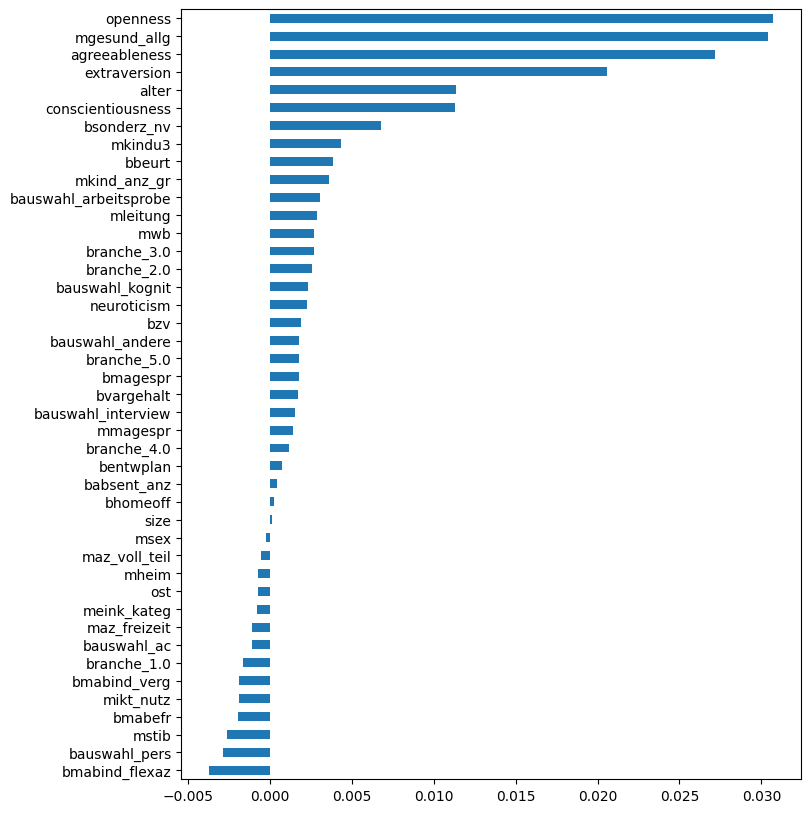

In [19]:
from sklearn.inspection import permutation_importance

fimp = permutation_importance(forest, X_test, y_test, n_repeats=30)

fimp.importances_mean

pd.Series(fimp.importances_mean, index=X.columns).sort_values().plot(kind='barh', figsize=(8, 10))


**Interpretation**
- Here for instance openness, mgesund_allg (i.e. health status) and agreeableness turn out to be important for the prediction.
- The Big5 Personality traits are very predictive. As a side note: These are evaluated subjectively in the same survey as engagement - hence, there are likely be affected by common shocks (such as mood at the day of the survey). Hence, the association tends to be high.
- Of the objectively measurable variables age (variable alter) is the most predictive one.
- The variables starting with a "b" come from a survey filled out by the employer. They are mostly binary variables assessing whethe a firm uses a certain practice or not. Check the LPP campus file documentation if you are interested.


\

Note:
- The feature importance tells us only whether a feature is important, but it does not tell us the direction of the association
- There are also some negative values down in the list. This here only tells us that the random perturbations of these variables actually (by chance) improved the prediction quality. Hence, you can conclude that these features are not very predictive




# **Partial Dependence Plots**
----

- The permutation feature importance above only told us whether a feature is important for the prediction, but not the direction of the association, or whether the association is monotonic or not
- To see the direction of the association we can simply plot the prediction
- We do this in partial dependence plots
- Below we plot  this for two variables mgesund_allg (health status) and alter (age)

\

Note:
- Importantly, the preditions are plotted holding all other variables constant at their mean (therefore "partial" dependence).
- Be careful when features are highly correlated.
- Moreover, when not exogenously varied the connections cannot be interpreted in a causal manner.
- But these plots are very useful to understand how the prediction works

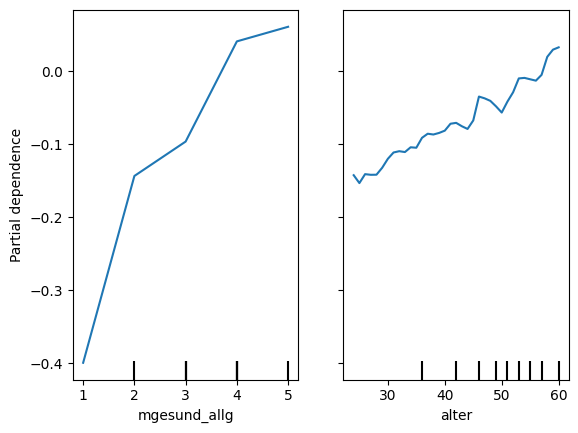

In [22]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(forest, X_train, ['mgesund_allg','alter'])




- You can also plot a two-dimensional depencence plot.
- This is particularly useful when expecting interaction effects.
- The following graph shows you the predicted engagement for combinations of age and health status: the old and healthy are the most engaged

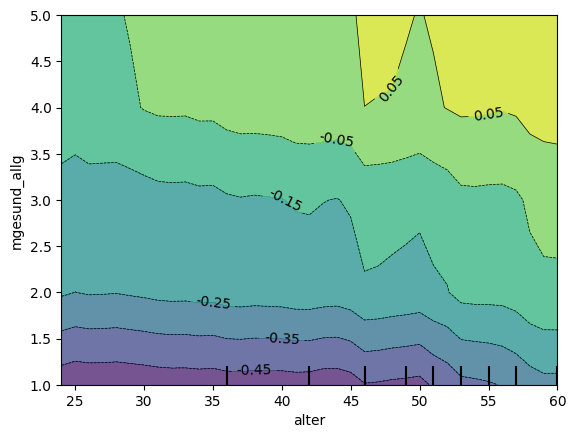

In [23]:
PartialDependenceDisplay.from_estimator(forest, X_train, [('alter','mgesund_allg')])

The following plots show plots for all the big 5. Note that for all of them higher values predict higher engagement except for neuroticism where the opposite pattern holds

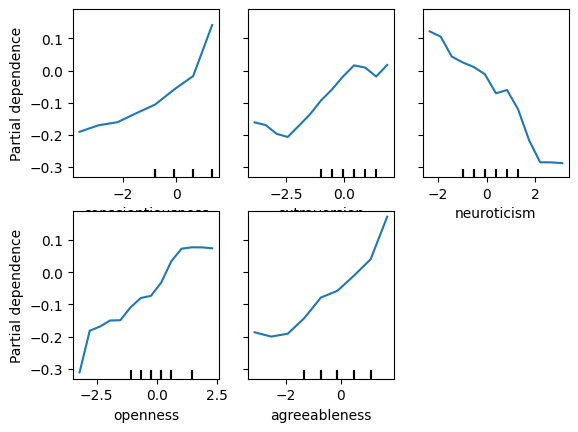

In [24]:
PartialDependenceDisplay.from_estimator(forest, X_train, ['conscientiousness', 'extraversion', 'neuroticism', 'openness', 'agreeableness'])